# Data Analysis

In this notebook I am performing data analysis on the scraped data for job listings.

### Table of contents

1. [Libraries and dataset](#Libraries-and-dataset)
2. [Initial Data Exploration](#Initial-Data-Exploration)
   1. [Visualizing the categorical data](#Visualizing-the-categorical-data)
   2. [Plotting word frequencies](#Plotting-word-frequencies)
3. [Text Pre-Processing](#Text-Pre-Processing)
   1. [Convert all text to lower case](#Convert-all-text-to-lower-case)
   2. [Remove special characters, unnecessary punctuation and digits](#Remove-special-characters,-unnecessary-punctuation-and-digits)
   3. [Tokenize and remove stop words](#Tokenize-and-remove-stop-words)
   4. [Lemmatize the description words](#Lemmatize-the-description-words)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
   1. [Wordcloud visualizations](#Wordcloud-visualizations)
   2. [Visualizing n-gram distributions](#Visualizing-n-gram-distributions)
5. [Conclusion](#Conclusion)

## Libraries and dataset

In [1]:
import sys
sys.path.append("..")
sys.path.append("../modeling/")

In [2]:
import pandas as pd                # Data processing
import matplotlib.pyplot as plt    # Data visualization purposes
import seaborn as sns              # Statistical data visualization
%matplotlib inline
sns.set_theme()                    # Allows seaborn to handle the plotting theme

Let's load our database.

In [3]:
from modeling.database import MongoDB
db = MongoDB()

## Initial Data Exploration

Firstly, let's retrieve all documents.

In [4]:
documents = db.get_all_documents()
df = pd.DataFrame(list(documents))

Here we delete the `id` and `url` columns as they are not useful for our data analysis.

Then we modify the `roles` column to only show the first role available as a singular record instead of a list.

The reason is that some job titles may have matched multiple roles, and therefore we keep the first one matched.

In [5]:
df = df.iloc[:, 3:].drop('last_accessed', axis=1)
df['roles'] = df['roles'].str[0]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   roles        221 non-null    object
 1   company      193 non-null    object
 2   location     221 non-null    object
 3   type         203 non-null    object
 4   industry     168 non-null    object
 5   workplace    174 non-null    object
 6   description  221 non-null    object
 7   level        137 non-null    object
dtypes: object(8)
memory usage: 13.9+ KB


Let's see how out dataset currently looks like.

In [6]:
df.head()

,roles,company,location,type,industry,workplace,description,level
0,Data Scientist,Dialectica,"Athens, Attiki, Greece",Full-time,Information Services,On-site,About The Tech Team\n\nTechnology powers every...,NaN
1,Data Scientist,Optasia,"Athens, Attiki, Greece",Full-time,Financial Services,On-site,Optasia is a fully-integrated B2B2X financial ...,NaN
2,Data Scientist,Incelligent,"Nea Smyrni, Attiki, Greece",Full-time,Telecommunications,On-site,We are looking for a bright Machine Learning E...,NaN
3,Data Scientist,WINGS ICT Solutions,"Nea Smyrni, Attiki, Greece",Full-time,Telecommunications,On-site,WINGS ICT WINGS ICT Solutions is looking for a...,NaN
4,Data Scientist,DEUS EX MACHINA,Thessaloniki Metropolitan Area,Full-time,NaN,On-site,"We are DEUS EX MACHINA, a technology company s...",NaN


We see that some of the data contain missing values. Let's explore the degree of such missing data in our dataset.

In [7]:
df.isnull().sum()

roles           0
company        28
location        0
type           18
industry       53
workplace      47
description     0
level          84
dtype: int64

Indeed, some of the columns contains significant amount of missing data. We will have to deal with this issue.

### Visualizing the categorical data

Let's begin by finding the distribution in the category columns of `roles` and `industry`.

In [8]:
df_role_count = df['roles'].value_counts()
df_role_count

Data Engineer     88
Data Analyst      57
Data Scientist    44
ML Engineer       32
Name: roles, dtype: int64

<AxesSubplot: >

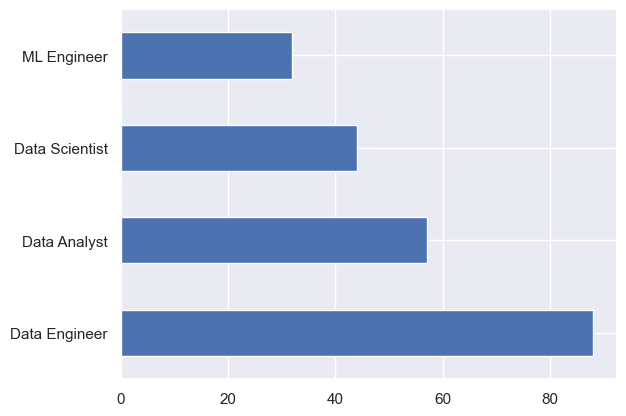

In [9]:
df_role_count.plot.barh()

In [10]:
df_industry_count = df['industry'].value_counts()
df_industry_count

IT Services and IT Consulting           50
Information Technology & Services       18
Human Resources                         15
IT                                      13
Staffing and Recruiting                 10
Pharmaceutical Manufacturing             8
Financial Services                       8
Software Development                     6
Business Consulting and Services         5
Telecommunications                       4
Professional Services                    3
Technology, Information and Internet     3
Automation Machinery Manufacturing       2
Entertainment Providers                  2
Engineering                              2
BI / Business Analysis                   2
Information Services                     2
Oil and Gas                              1
Call Center / Customer Support           1
Food & Beverages                         1
Gambling Facilities and Casinos          1
Photography                              1
Semiconductors                           1
Insurance  

We can see that the different websites name their industry categories differently. We can group them in a more concise way.

In [11]:
def simplify_industry(industry):
    if industry == 'IT':
        return 'IT Services and IT Consulting'
    elif industry == 'BI / Business Analysis':
        return 'Business Consulting and Services'
    elif industry == 'Marketing / Advertising':
        return 'Market Research'
    elif industry == 'Finance':
        return 'Financial Services'
    elif 'manufacturing' in str(industry).lower():
        return 'Manufacturing'
    else:
        return industry

df['industry'] = df['industry'].apply(simplify_industry)

Plot the top 10 industry types that we found in the dataset.

<AxesSubplot: >

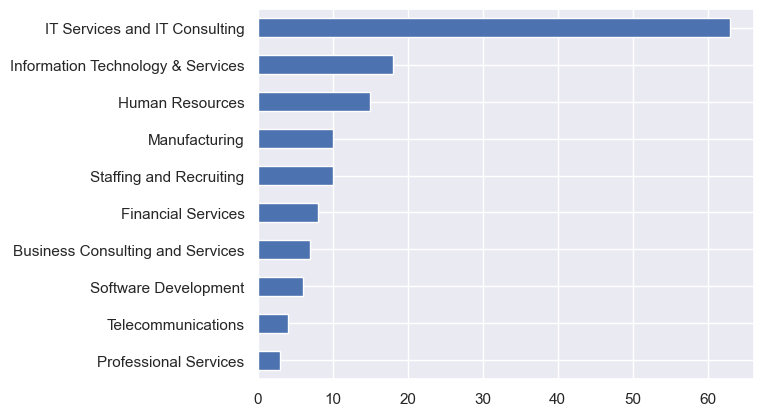

In [12]:
df_industry_count = df['industry'].value_counts()
df_industry_count.sort_values(ascending=True, inplace=True)
df_industry_count.tail(10).plot.barh()

Next we will see the columns describing the `workplace` and the `level`. We also unify the results from all websites.

In [13]:
df_work_count = df['workplace'].value_counts()
df_work_count

On-site        95
Remote         46
Hybrid         27
Part remote     4
Full remote     2
Name: workplace, dtype: int64

In [14]:
df['workplace'] = df['workplace'].replace({'Part remote': 'Hybrid', 'Temporarily remote': 'Remote', 'Full remote': 'Remote'})
df_work_count = df['workplace'].value_counts()

Notice that the `level` column has the most **null** values, which we will probably drop later on.

In [15]:
df_level_count = df['level'].value_counts()
df_level_count

Mid-Senior level    54
Entry level         50
Mid level           13
Associate           11
Senior               4
Director             3
Entry/Junior         2
Name: level, dtype: int64

In [16]:
df['level'] = df['level'].replace({'Mid-Senior level': 'Mid-Senior', 'Entry level': 'Junior', 'Entry/Junior': 'Junior',
                                   'Mid level': 'Mid-Senior', 'Director': 'Senior'})
df_level_count = df['level'].value_counts()

Let's create some pie charts to showcase the distribution of these two columns (`workplace`, `level`).

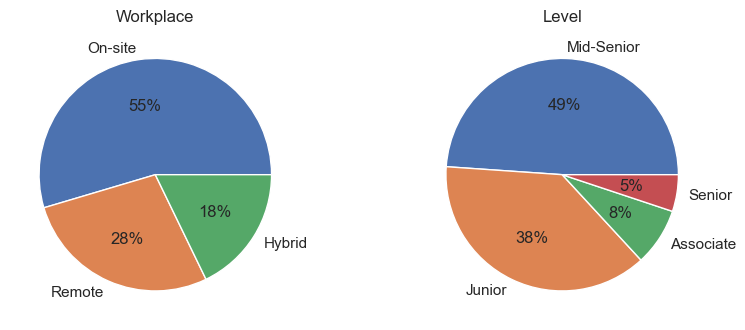

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
plt.subplots_adjust(wspace=0.4)

axes[0].pie(df_work_count, labels=df_work_count.index, autopct='%.0f%%')
axes[0].set_title("Workplace")

axes[1].pie(df_level_count, labels=df_level_count.index, autopct='%.0f%%')
axes[1].set_title("Level")

plt.show()

### Plotting word frequencies

To begin with, I want to see what is the word distribution in the entire corpus.

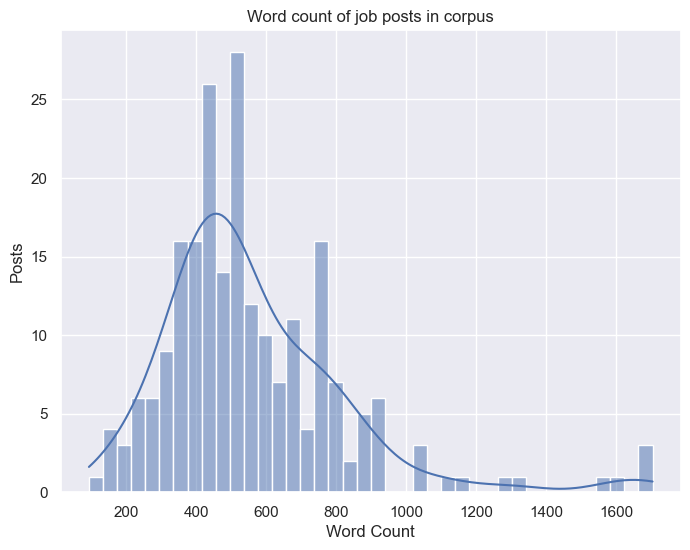

In [18]:
word_count = df['description'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,6))
sns.histplot(data=word_count, bins=40, element='bars', kde=True)
plt.title('Word count of job posts in corpus')
plt.xlabel('Word Count')
plt.ylabel('Posts')
plt.show()

In [19]:
print(f'Minumum post length:\t {word_count.min()}')
print(f'Mean post length:\t {int(word_count.mean())}')
print(f'Maximum post length:\t {word_count.max()}')

Minumum post length:	 94
Mean post length:	 562
Maximum post length:	 1703


Then, I show the 20 most common words in the whole corpus.

<AxesSubplot: xlabel='word'>

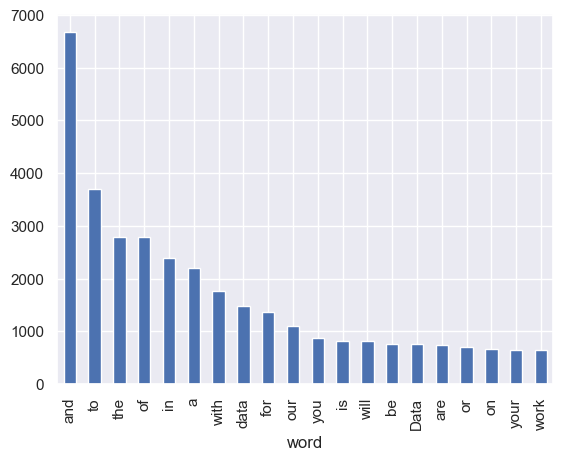

In [20]:
from collections import Counter
corpus_ct = Counter(" ".join(df["description"]).split()).most_common(20)
df_corpus = pd.DataFrame.from_dict(corpus_ct)
df_corpus = df_corpus.rename(columns={0: "word", 1: "count"})

df_corpus.plot.bar(x='word', y='count', legend=False)

Let's break it down to the 20 most common words in each `role` category.

In [21]:
ds_ct    = Counter(" ".join(df[df['roles']=='Data Scientist']["description"]).split()).most_common(20)
ai_ct    = Counter(" ".join(df[df['roles']=='Data Analyst']["description"]).split()).most_common(20)
ml_ct    = Counter(" ".join(df[df['roles']=='ML Engineer']["description"]).split()).most_common(20)
mlops_ct = Counter(" ".join(df[df['roles']=='Data Engineer']["description"]).split()).most_common(20)

In [22]:
df_ds = pd.DataFrame.from_dict(ds_ct)
df_ds = df_ds.rename(columns={0: "word", 1: "count"})

df_ai = pd.DataFrame.from_dict(ai_ct)
df_ai = df_ai.rename(columns={0: "word", 1: "count"})

df_ml = pd.DataFrame.from_dict(ml_ct)
df_ml = df_ml.rename(columns={0: "word", 1: "count"})

df_mlops = pd.DataFrame.from_dict(mlops_ct)
df_mlops = df_mlops.rename(columns={0: "word", 1: "count"})

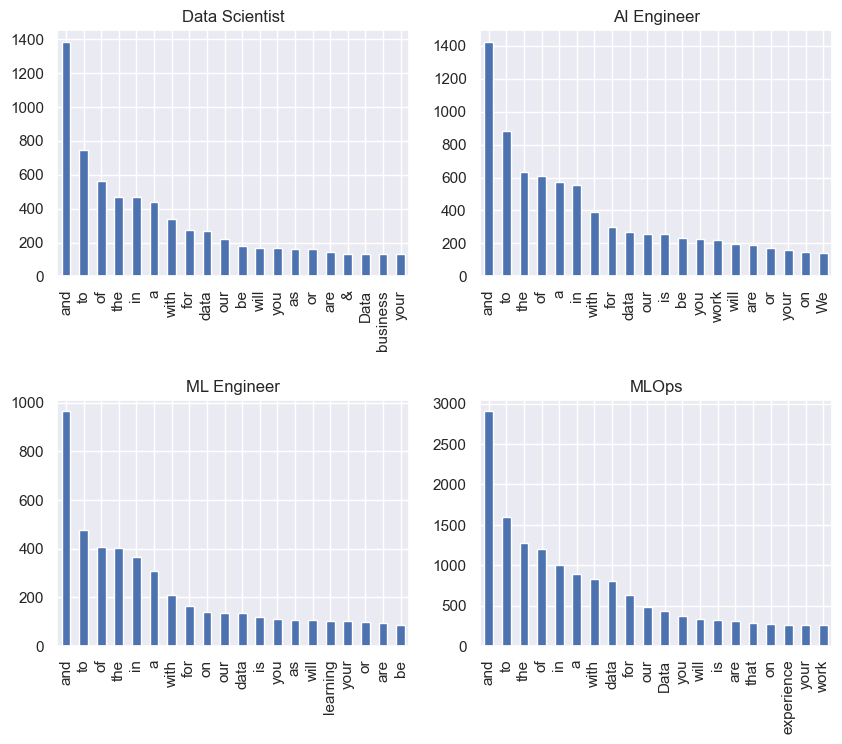

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)

df_ds.plot.bar(x='word', y='count', legend=False, ax=axes[0,0])
axes[0,0].set_title('Data Scientist')
axes[0,0].set(xlabel=None)

df_ai.plot.bar(x='word', y='count', legend=False, ax=axes[0,1])
axes[0,1].set_title('AI Engineer')
axes[0,1].set(xlabel=None)

df_ml.plot.bar(x='word', y='count', legend=False, ax=axes[1,0])
axes[1,0].set_title('ML Engineer')
axes[1,0].set(xlabel=None)

df_mlops.plot.bar(x='word', y='count', legend=False, ax=axes[1,1])
axes[1,1].set_title('MLOps')
axes[1,1].set(xlabel=None)

plt.show()

As we can see, the most common words are either *propositions*, *conjuctions* or *pronouns*.

Some entries are also not words but symbols or punctuation.

Later we will try to eliminate those as they should have no influence on the training of our model.

## Text Pre-Processing

This part, called *text pre-processing*, is where we perform various transformations to the raw dataset's fields.

In detail, we will perform the following transformations:

1. [Text cleaning](#Text-cleaning)
2. [Tokenize sentences](#Tokenize-sentences)
3. [POS Tagging](#POS-Tagging)
4. [Remove stop words](#Remove-stop-words)
5. [Normalization](#Normalization)

### Text cleaning

In [24]:
df['description'] = df['description'].apply(lambda x: x.lower())               # Convert to lower case
df['description'] = df['description'].str.replace(r'[^\w\s]', ' ', regex=True) # Remove special characters
df['description'] = df['description'].str.replace(r'\d+', '', regex=True)      # Remove digits
df['description'] = df['description'].str.replace(r'\s*\n+', ' ', regex=True)  # Remove new lines and whitespaces
df['description'].head()

0    about the tech team technology powers everythi...
1    optasia is a fully integrated bbx financial te...
2    we are looking for a bright machine learning e...
3    wings ict wings ict solutions is looking for a...
4    we are deus ex machina  a technology company s...
Name: description, dtype: object

### Tokenize sentences

Tokenization is an important part of NLP as it transforms sentences into smaller units (tokens) that easier to work with.

In our case I am going to use word tokens.

In [25]:
from nltk.tokenize import word_tokenize

df['description'] = df['description'].apply(lambda x: word_tokenize(x))
df['description'].head()

0    [about, the, tech, team, technology, powers, e...
1    [optasia, is, a, fully, integrated, bbx, finan...
2    [we, are, looking, for, a, bright, machine, le...
3    [wings, ict, wings, ict, solutions, is, lookin...
4    [we, are, deus, ex, machina, a, technology, co...
Name: description, dtype: object

### POS Tagging

Part-of-speech tagging is the process of labeling words in a corpus to indicate a corresponding *part of speech* (e.g noun, verb, adjective etc.), based on its definition and context. After successful tagging, we may be able to understand the distribution of such parts of speech in our dataset.

In [26]:
#nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag

df['description'] = df['description'].apply(lambda x: pos_tag(x))
df['description'].head()

0    [(about, IN), (the, DT), (tech, NN), (team, NN...
1    [(optasia, NN), (is, VBZ), (a, DT), (fully, RB...
2    [(we, PRP), (are, VBP), (looking, VBG), (for, ...
3    [(wings, NNS), (ict, VBP), (wings, NNS), (ict,...
4    [(we, PRP), (are, VBP), (deus, JJ), (ex, FW), ...
Name: description, dtype: object

It will be easier for us to group the different parts of speech if we combine all the tagged tokens.

In [27]:
group = [word for pos_desc in df['description'].tolist() for word in pos_desc]
group_df = pd.DataFrame(group, columns = ('word','pos'))
group_df.head()

,word,pos
0,about,IN
1,the,DT
2,tech,NN
3,team,NN
4,technology,NN


In [28]:
group_df['pos'].value_counts().nlargest(5)

NN     32847
NNS    15339
JJ     14689
IN     13364
CC      7681
Name: pos, dtype: int64

Let's see the first 250 words that were categorized as nouns (NN or NNS).

In [29]:
noun_tags = group_df[(group_df['pos']=='NN') | (group_df['pos']=='NNS')]
noun_tags_list = noun_tags['word'].head(250).unique().tolist()

print(', '.join(map(repr, noun_tags_list)))

'tech', 'team', 'technology', 'powers', 'everything', 'dialectica', 'clients', 'expert', 'profiles', 'minutes', 'thousands', 'pieces', 'information', 'day', 'web', 'application', 'delivery', 'market', 'services', 'technologies', 'role', 'designs', 'engineers', 'software', 'methodologies', 'data', 'scientists', 'engineering', 'product', 'business', 'analysis', 'professionals', 'science', 'models', 'tools', 'insights', 'power', 'analytics', 'investment', 'decisions', 'responsibilities', 'mathematics', 'statistics', 'volumes', 'solutions', 'machine', 'learning', 'impact', 'effort', 'set', 'datasets', 'operationalize', 'maintain', 'partner', 'stakeholders', 'leadership', 'intersection', 'intelligence', 'skills', 'drive', 'novel', 'algorithms', 'products', 'requirements', 'candidate', 'phd', 'computer', 'field', 'years', 'post', 'experience', 'python', 'complexity', 'ml', 'techniques', 'language', 'processing', 'transformer', 'concepts', 'programming', 'etc', 'passionate', 'ideas', 'values'

We can see that the desired tools to extract (e.g Python, etc.) are mostly nouns. This is a good indication for which parts of speech to prioritize.

### Remove stop words

Stop words are called the words that are commonly used (e.g "the", "or", "and", etc.) and they don't provide any valuable context to the corpus. We need to remove those stop words as this process will speed up our processing time and free up space in our dataset. 

In [30]:
#nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['description'] = df['description'].apply(lambda x: [word for word in x if word[0] not in stop_words])
df['description'].head()

0    [(tech, NN), (team, NN), (technology, NN), (po...
1    [(optasia, NN), (fully, RB), (integrated, JJ),...
2    [(looking, VBG), (bright, JJ), (machine, NN), ...
3    [(wings, NNS), (ict, VBP), (wings, NNS), (ict,...
4    [(deus, JJ), (ex, FW), (machina, FW), (technol...
Name: description, dtype: object

### Normalization

Normalization of text in a corpus can be achieved by two different methods, namely **Lemmatization** and **Stemming**. Both of these methods aim to reduce the amount of excess information in order to improve efficiency. *Lemmatization* is the process of converting each word to its meaningful base form, which is called a *Lemma*. On the other hand *stemming* is used to analyze the meaning behind a word. While *lemmatization* is preferred for context analysis, *stemming* is recommended when the context is not important or in case of large dataset where performance is an issue.

In [31]:
from nltk.corpus import wordnet

def get_tag_mapping(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    elif tag.startswith('V'):
        return wordnet.VERB
    else:
        return wordnet.NOUN

In [32]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

df['description'] = df['description'].apply(lambda x: [wnl.lemmatize(word, get_tag_mapping(tag)) for word, tag in x])
df['description'].head()

0    [tech, team, technology, power, everything, di...
1    [optasia, fully, integrated, bbx, financial, t...
2    [look, bright, machine, learn, engineer, join,...
3    [wing, ict, wing, ict, solution, look, enthusi...
4    [deus, ex, machina, technology, company, speci...
Name: description, dtype: object

Now that we cleaned our dataset, let's observe again the most common words that represent our corpus.

<AxesSubplot: xlabel='word'>

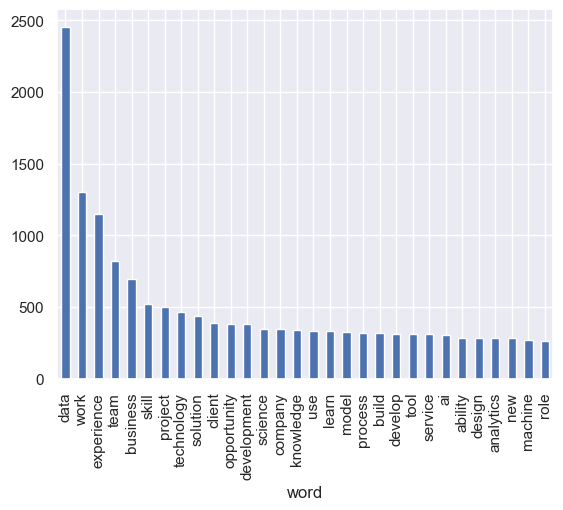

In [33]:
out = df['description'].explode().value_counts().reset_index()[:30]

df_corpus = pd.DataFrame.from_dict(out)
df_corpus = df_corpus.rename(columns={"index": "word", "description": "count"})

df_corpus.plot.bar(x='word', y='count', legend=False)

As seen by the bar plot, our corpus contains more meaningful words than previously. This indicates that we clean the dataset correctly.

### Single character removal

Sometimes, after text cleaning and tagging, there may still exist single character word tokens, for example after cleaning the "e.g." acronym.

Let's attempt to remove such characters from our text.

In [34]:
thrueshold = 1

chars = df['description'].apply(lambda x: [word for word in x if len(word) == thrueshold])
chars.explode().value_counts()

e    196
u    188
g    164
r     84
c     41
b     24
m     13
k      9
j      9
l      6
v      4
η      4
p      2
ή      2
h      1
f      1
α      1
ε      1
ο      1
o      1
Name: description, dtype: int64

In [35]:
df['description'] = df['description'].apply(lambda x: [word for word in x if len(word) > thrueshold])

## Exploratory Data Analysis

Exploratory data analysis (EDA) is used in data science in order to investigate data sets, exploring their main characteristics. It usually involves the usage of visualization methods and graphics in order to make it easier for data scientists to discover patterns, anomalies and check assumptions.

### Wordcloud visualizations

Wordcloud is a concise way to represent text data where the size and color of each word that appears, indicate it’s frequency in the corpus. We are going to use the `wordcloud` package to visualize and show the most common tokens in each role.

First, let's check the unique roles we can find in the preprocessed dataset and then append all tokens to each respective role.

In [36]:
# Keep only the columns that we care for, roles and description
df = df[["roles", "description"]]

# Put description tokens into a single list based on the role they were found in
role_descs = df.groupby(["roles"]).sum().reset_index()
role_descs.head()

,roles,description
0,Data Analyst,"[challenger, bank, southeast, europe, regional..."
1,Data Engineer,"[optasia, fully, integrated, bbx, financial, t..."
2,Data Scientist,"[tech, team, technology, power, everything, di..."
3,ML Engineer,"[poudouleveis, gr, behalf, kaizen, gaming, kai..."


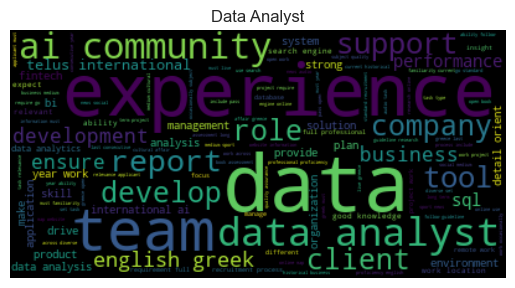

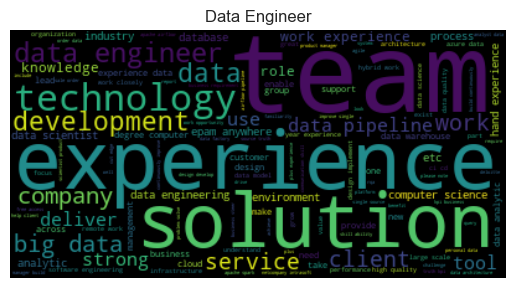

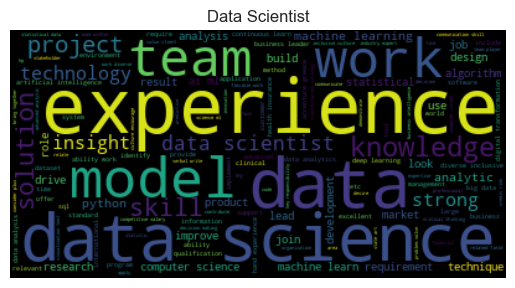

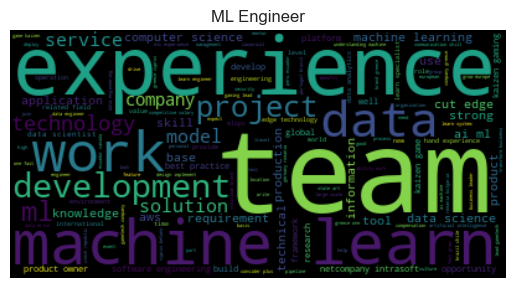

In [37]:
from wordcloud import WordCloud

role_list = role_descs['roles'].unique().tolist()

for role in role_list:
    # Get all tokens for the active job role
    tokens = role_descs[role_descs['roles'] == role].iloc[0].description

    # Generate a word cloud image from said tokens
    wordcloud = WordCloud().generate_from_text(' '.join(tokens))

    # Display wordcloud graphic
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(role)
    plt.show()

As shown in the wordclouds, we did a good job cleaning the dataset as each role is described by very closely assosiated words.

### Visualizing n-gram distributions

In essence, the term *n-grams* refers to the sequence of N words or characters. The naming convention starts with unigram, bigrams, trigrams and n-grams.

Let's compute the bi-grams and tri-grams of the entire corpus and then identify them for each role. As you can imagine the unigram computation will just yield our most common words we saw earlier.

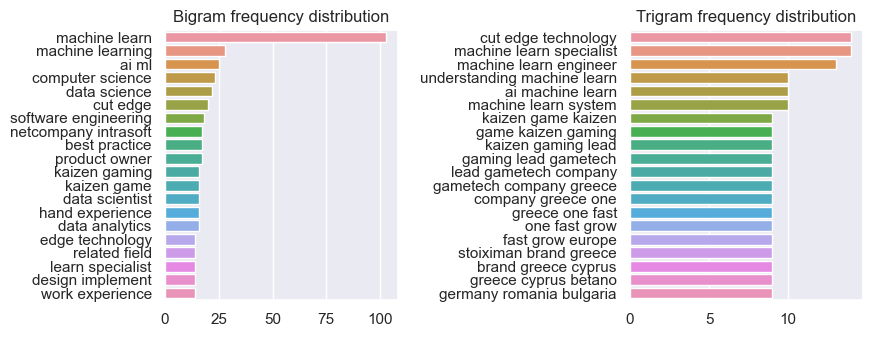

In [38]:
from nltk import FreqDist
from nltk.util import ngrams

def generate_ngrams(tokens, n):
    n_gram          = ngrams(tokens, n)
    n_gram_dist     = FreqDist(n_gram).most_common(20)
    
    # Join bigram tokens with '_' + maintain sorting
    n_gram_joined   = {' '.join(k):v for k,v in sorted(n_gram_dist, key=lambda item:item[1], reverse=True)}
    
    # Convert to Pandas series for easy plotting
    n_gram_freqdist = pd.Series(n_gram_joined)
    return n_gram_freqdist

bi_gram_freqdist  = generate_ngrams(tokens, 2)
tri_gram_freqdist = generate_ngrams(tokens, 3)

# Generate two plots for bigrams and trigrams
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
plt.subplots_adjust(wspace=1, hspace=0.4)

bg = sns.barplot(x=bi_gram_freqdist.values, y=bi_gram_freqdist.index, orient='h', ax=axes[0])
axes[0].set_title(f'Bigram frequency distribution')

tg = sns.barplot(x=tri_gram_freqdist.values, y=tri_gram_freqdist.index, orient='h', ax=axes[1])
axes[1].set_title(f'Trigram frequency distribution')

plt.show()

Let's now compute bigrams and trigrams for each individual role in the data set and compare them.

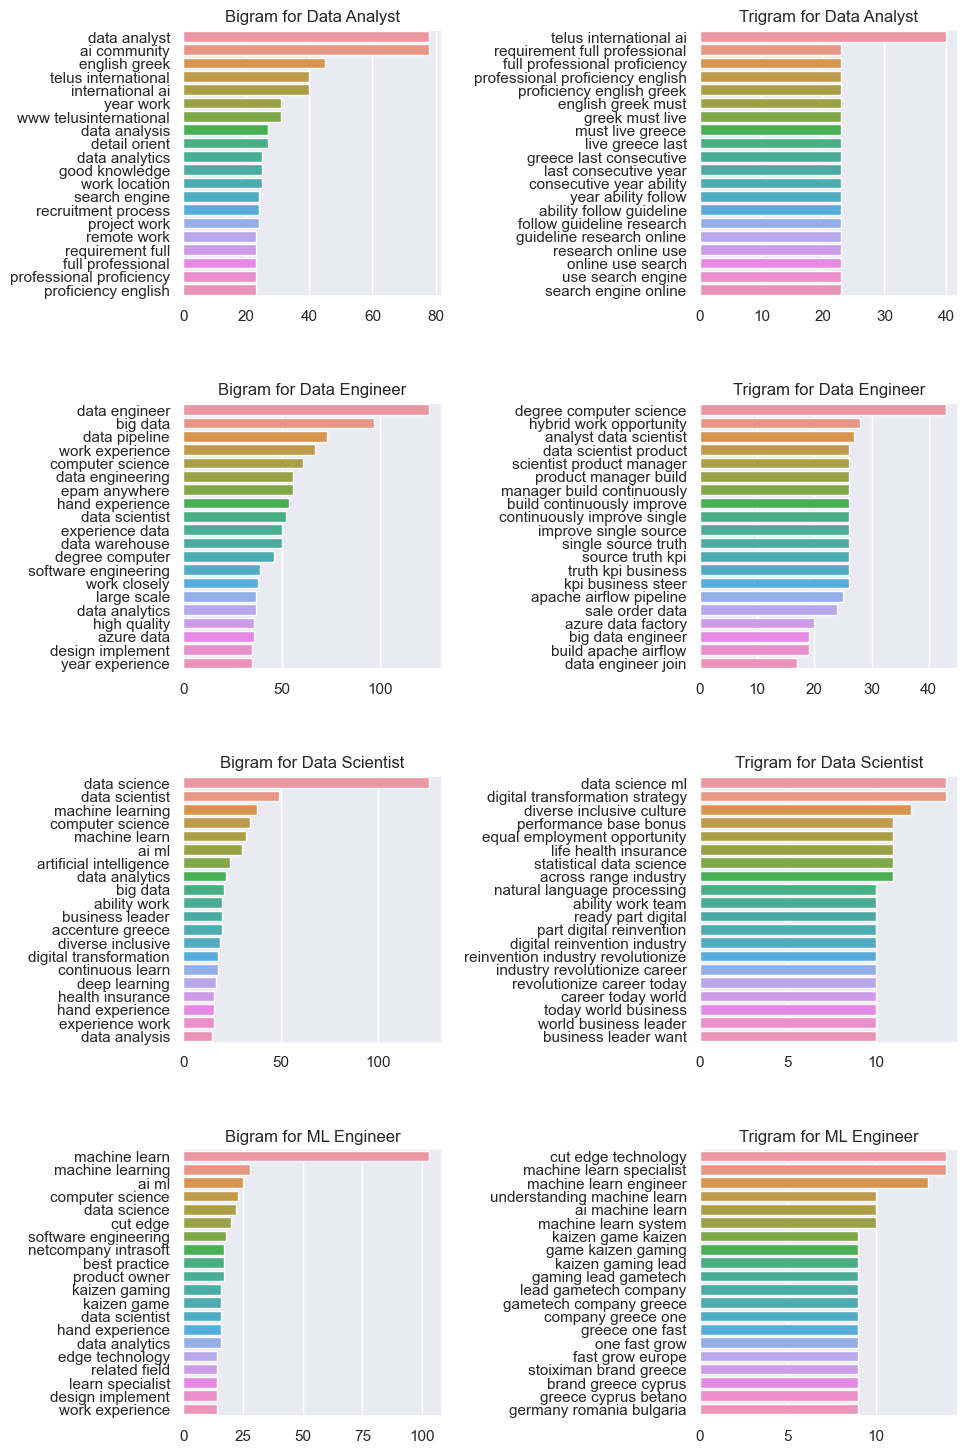

In [39]:
from nltk import FreqDist
from nltk.util import ngrams  

fig, axes = plt.subplots(4, 2, figsize=(10, 18))
plt.subplots_adjust(wspace=1, hspace=0.4)

for index, role in enumerate(role_list):
    tokens = role_descs[role_descs['roles'] == role].iloc[0].description

    bi_gram_freqdist  = generate_ngrams(tokens, 2)
    tri_gram_freqdist = generate_ngrams(tokens, 3)
    
    # Plotting
    bp1 = sns.barplot(x=bi_gram_freqdist.values, y=bi_gram_freqdist.index, orient='h', ax=axes[index, 0])
    axes[index,0].set_title(f'Bigram for {role}')
    
    bp2 = sns.barplot(x=tri_gram_freqdist.values, y=tri_gram_freqdist.index, orient='h', ax=axes[index, 1])
    axes[index,1].set_title(f'Trigram for {role}')
    
plt.show()

## Conclusion

In this notebook I performed an initial exploration of the scraped data set. I identified the rate of missing (null) values as well as visualizing the different categorical data and word frequencies. Next, I performed text pre-processing in which I carried out various transformations in the data set in order to improve the quality by eliminating any uneccesary context. This allowed me to identify that skills are mostly in the form of nouns and also allowed for a better and cleaner data set as indicated by wordcloud plots. Lastly I created bar plots that showcase the extracted bigrams and trigrams. These plots show the most common phrases that are closely related with each role.